<a href="https://colab.research.google.com/github/KryssyCo/DS-Unit-2-Tree-Ensembles/blob/master/Krista_Shepard_DS5_S7M1_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Decision Tree Classifier. 
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top of this notebook.
- Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.


In [18]:
pip install category_encoders

In [19]:
!pip install pdpbox category_encoders pandas==0.23.4

In [20]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'

train = pd.merge(pd.read_csv(WEB + 'train_features.csv'), 
                 pd.read_csv(WEB + 'train_labels.csv'))
test = pd.read_csv(WEB + 'test_features.csv')
sample_submission = pd.read_csv(WEB + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.70, test_size=0.30, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((41580, 41), (17820, 41), (14358, 40))

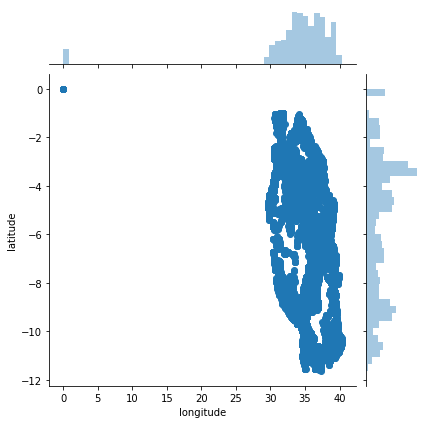

In [22]:
sns.jointplot(x='longitude', y='latitude', data=train);

In [23]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,41580.000000,41580.000000,41580.000000,41580.000000,4.158000e+04,41580.000000,41580.000000,41580.000000,41580.000000,41580.000000
mean,37053.095238,328.297768,670.883333,34.088923,-5.716324e+00,0.500000,15.198509,5.593218,180.270178,1303.064791
std,21379.253543,3380.560532,693.624472,6.541418,2.940352e+00,14.103926,17.463795,9.575067,462.724333,950.851187
min,0.000000,0.000000,-63.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18530.750000,0.000000,0.000000,33.097738,-8.543252e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37055.500000,0.000000,374.000000,34.911885,-5.036156e+00,0.000000,12.000000,3.000000,27.500000,1986.000000
75%,55351.250000,25.000000,1322.000000,37.169114,-3.328690e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,15300.000000,2013.000000


In [0]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['population', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
#         X[col] = X[col].replace(0, X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

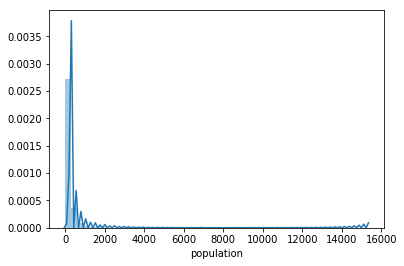

In [30]:
sns.distplot(train['population']);

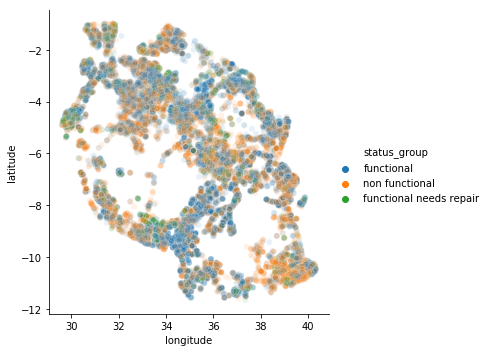

In [31]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.1);

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [34]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7292929292929293


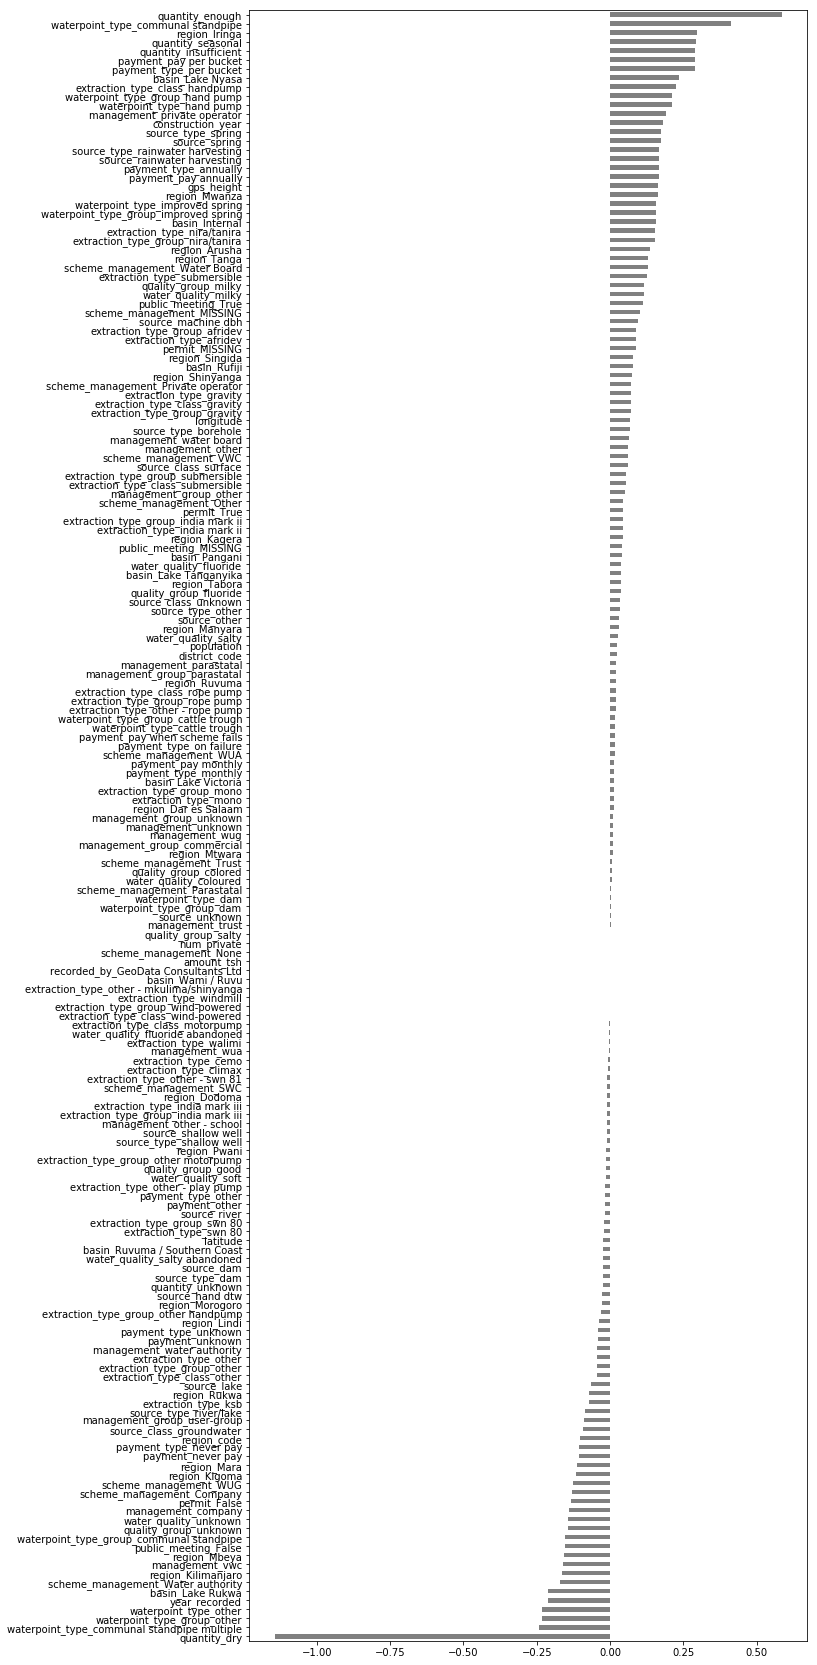

In [35]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [0]:
train_location = X_train[['population', 'longitude', 'latitude']].copy()
val_location = X_val[['population', 'longitude', 'latitude']].copy()

In [55]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
lr.fit(train_location, y_train)
print('Logistic Regression:')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression:
Train Accuracy 0.543073593073593
Validation Accuracy 0.5430976430976431


In [56]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_location, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree:
Train Accuracy 0.9841510341510341
Validation Accuracy 0.6273288439955107


In [57]:
dt = DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
dt.fit(train_location, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree:
Train Accuracy 0.7066618566618567
Validation Accuracy 0.6461840628507295


In [0]:
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

In [0]:
from google.colab import files
files.download('submission-02.csv')